In [1]:
!pip install transformers

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Load Data

In [4]:
# # Importing the dataset
data_columns=['id','subject','target','text']
df_train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', names = data_columns )

df_train.sample(5)


,id,subject,target,text
21211,4032,CS-GO,Irrelevant,Tonight at 19: 00 our CS: GO Team Anger Manage...
33541,6562,Fortnite,Negative,@ FortniteGame fortnite take the lightsabers i...
62550,5123,GrandTheftAuto(GTA),Negative,Only roll play yo we're tired where the fuck i...
45401,11794,Verizon,Irrelevant,Police might help cops acquire military weapon...
9696,12871,Xbox(Xseries),Positive,"Ahh, the calm before the . . Talked to a few ..."


In [5]:
df_valid = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names = data_columns )
df_valid.sample(5)

,id,subject,target,text
142,5473,Hearthstone,Neutral,YOUR PATHETIC Freeze Cannot Stop MY MINIONS | ...
807,6361,FIFA,Neutral,Man FIFA 19 was my game despite how shit it wa...
526,11244,TomClancysRainbowSix,Neutral,Absolutely love my amazing sister who has made...
52,6022,FIFA,Negative,More FIFA? Leslie Steiger must be joking! See ...
177,4343,CS-GO,Neutral,cs go ranked! ENG/CRO #fresh twitch.tv/vugidrugi


About Data

In [6]:
print("Length of train data:",len(df_train))
print("Length of test data:",len(df_valid))


Length of train data: 74682
Length of test data: 1000


In [7]:
print("Shape of train data:",df_train.shape)
print("Shape of test data:",df_valid.shape)

Shape of train data: (74682, 4)
Shape of test data: (1000, 4)


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       74682 non-null  int64 
 1   subject  74682 non-null  object
 2   target   74682 non-null  object
 3   text     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [9]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1000 non-null   int64 
 1   subject  1000 non-null   object
 2   target   1000 non-null   object
 3   text     1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [10]:
# Check for null values

np.sum(df_train.isnull().any(axis=1))

686

In [11]:
df_train = df_train.dropna()
print(df_train.shape)

(73996, 4)


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       73996 non-null  int64 
 1   subject  73996 non-null  object
 2   target   73996 non-null  object
 3   text     73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [13]:
np.sum(df_valid.isnull().any(axis=1))

0

In [14]:
df_train['target'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [15]:
df_valid['target'].unique()

array(['Irrelevant', 'Neutral', 'Negative', 'Positive'], dtype=object)

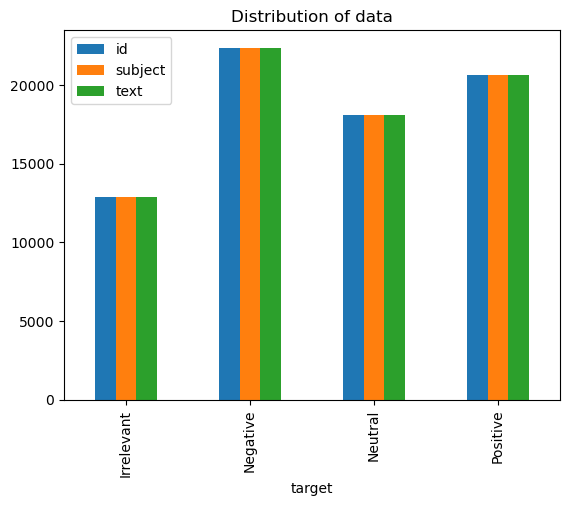

In [16]:
#Plot the Data 
ax = df_train.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=True)
# Storing data in lists.
text, sentiment = list(df_train['text']), list(df_train['target'])

<Axes: xlabel='target', ylabel='count'>

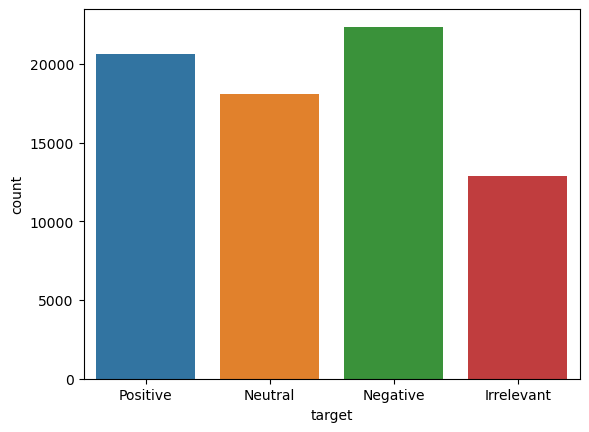

In [17]:
import seaborn as sns
sns.countplot(x='target', data=df_train)

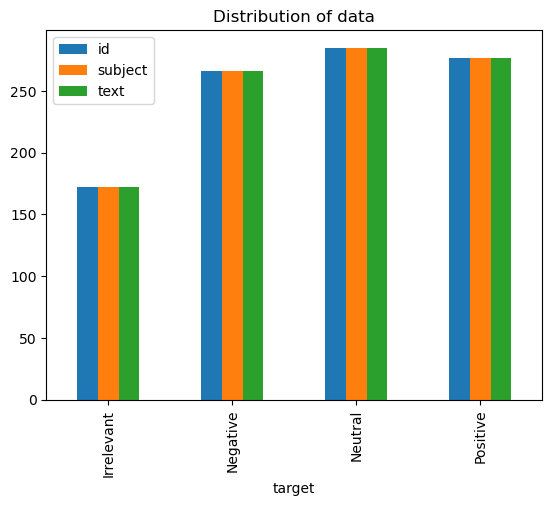

In [18]:
ax = df_valid.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=True)

<Axes: xlabel='target', ylabel='count'>

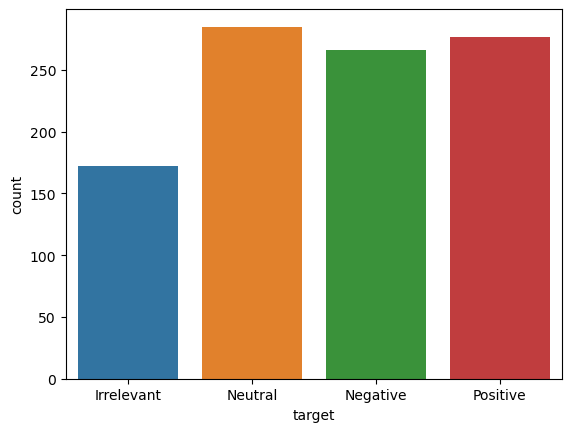

In [19]:
sns.countplot(x='target', data=df_valid)

Encoding the Labels

In [20]:
possible_labels = df_train.target.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Positive': 0, 'Neutral': 1, 'Negative': 2, 'Irrelevant': 3}

In [21]:
df_train['target'] = df_train.target.replace(label_dict)

In [22]:
df_train.sample(10)

,id,subject,target,text
45512,11813,Verizon,0,The Verizon network is now in full swing
55749,2370,CallOfDuty,2,C4 stinks . store.playstation.com/
42783,10139,PlayerUnknownsBattlegrounds(PUBG),2,Indian government ban PUBG. Pro PUBG player st...
32675,6404,Fortnite,3,@whoisaddison I threw a fortnite montage at you:)
25761,822,AssassinsCreed,0,The best RhandlerR RhandlerR pic.twitter.com/P...
10878,13071,Xbox(Xseries),1,It’s hard to overcome how damaging the ‘halo i...
69906,3978,Cyberpunk2077,2,I'm exhausted by Cyberpunk 2077 and it's not e...
8827,9514,Overwatch,2,OH. I always hated to play trackers when I'm o...
18019,9889,PlayStation5(PS5),2,This is somehow the worst packaging for a cons...
44998,11727,Verizon,1,Best Unlimited Business Data Service Plans : C...


In [23]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [24]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train.text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
df_valid['target'] = df_valid.target.replace(label_dict)

In [26]:
df_valid.sample(10)

,id,subject,target,text
24,526,ApexLegends,1,Umm @PlayApex when I died it said Bug This pi...
76,9857,PlayStation5(PS5),0,oooooh shit i think my motherboard is already ...
779,3898,Cyberpunk2077,0,Yaaaas! \n\nI want to see Keanu animated in an...
874,9533,Overwatch,2,holy balls this is unreal
113,3488,Facebook,1,"Congratulations to all nominees, including our..."
691,11590,TomClancysRainbowSix,1,@Rainbow6Game actived the ranked
180,3617,Cyberpunk2077,0,Playing through the Witcher 3 again and the No...
369,10722,RedDeadRedemption(RDR),0,"Thanks @RockstarGames , you're rock stars! #R..."
385,6694,Fortnite,2,NOT FREE TO USE !!!! Recent work #Fortnite pic...
504,49,Amazon,1,I played this interesting quiz on Amazon - Try...


In [27]:
encoded_data_val = tokenizer.batch_encode_plus(
    df_valid.text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
input_ids_train = encoded_data_train['input_ids'].to(device)
attention_masks_train = encoded_data_train['attention_mask'].to(device)
labels_train = torch.tensor(df_train.target.values).to(device)

input_ids_val = encoded_data_val['input_ids'].to(device)
attention_masks_val = encoded_data_val['attention_mask'].to(device)
labels_val = torch.tensor(df_valid.target.values).to(device)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [29]:
# dataset_train = dataset_train.to(device)
# dataset_val = dataset_val.to(device)

In [30]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [31]:
model=model.to(device)

In [32]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [33]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [35]:
from tqdm import tqdm

In [36]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [37]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

epoch = 1
progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        # progress_bar.update() 
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

Epoch 1:   0%|          | 0/24666 [00:00<?, ?it/s]
                                                                                   

  0%|          | 0/5 [44:11<?, ?it/s]

  0%|          | 0/5 [44:11<?, ?it/s]


Epoch 1
Training loss: 0.8553158609882675




  0%|          | 0/5 [44:20<?, ?it/s]

 20%|██        | 1/5 [44:20<2:57:21, 2660.40s/it]

Validation loss: 0.30367384073575454
F1 Score (Weighted): 0.9267329505202098




 20%|██        | 1/5 [1:26:35<2:57:21, 2660.40s/it]

 20%|██        | 1/5 [1:26:35<2:57:21, 2660.40s/it]


Epoch 2
Training loss: 0.4260161759989525




 20%|██        | 1/5 [1:26:44<2:57:21, 2660.40s/it]

 40%|████      | 2/5 [1:26:44<2:09:36, 2592.14s/it]

Validation loss: 0.20583290465252438
F1 Score (Weighted): 0.9650154763576316




 40%|████      | 2/5 [2:08:58<2:09:36, 2592.14s/it]

 40%|████      | 2/5 [2:08:58<2:09:36, 2592.14s/it]


Epoch 3
Training loss: 0.21406554961417087




 40%|████      | 2/5 [2:09:07<2:09:36, 2592.14s/it]

 60%|██████    | 3/5 [2:09:07<1:25:39, 2569.66s/it]

Validation loss: 0.19704675793323048
F1 Score (Weighted): 0.9669963914149523




 60%|██████    | 3/5 [2:51:15<1:25:39, 2569.66s/it]

 60%|██████    | 3/5 [2:51:15<1:25:39, 2569.66s/it]


Epoch 4
Training loss: 0.11737345941192934




 60%|██████    | 3/5 [2:51:25<1:25:39, 2569.66s/it]

 80%|████████  | 4/5 [2:51:25<42:36, 2556.95s/it]  

Validation loss: 0.2596924337006761
F1 Score (Weighted): 0.9639746539856556




 80%|████████  | 4/5 [3:33:40<42:36, 2556.95s/it]

 80%|████████  | 4/5 [3:33:40<42:36, 2556.95s/it]


Epoch 5
Training loss: 0.07859361965943538




 80%|████████  | 4/5 [3:33:49<42:36, 2556.95s/it]

100%|██████████| 5/5 [3:33:49<00:00, 2565.84s/it]

Validation loss: 0.24557897699988332
F1 Score (Weighted): 0.9700060717375796


In [38]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/kaggle/working/finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Class: Positive
Accuracy: 270/277

Class: Neutral
Accuracy: 276/285

Class: Negative
Accuracy: 256/266

Class: Irrelevant
Accuracy: 163/172

